**Instructions:**

Tasks in this homework are based on what is covered in laboratory exercises 7 and 8.

When you finish, download and upload the notebook file in .ipynb format to c3 homework 4 assignment section.

# **Course: Fundamental Concepts of AI**
# **Homework 4: Simple Computer Vision - Image Classification Using CNNs in Keras**

**Student name and surname:**
Almir Mustafic
**Student index:**
20114
**Date:**
January 12, 2025



#Assignment 1: MEDMNIST medical images classification (3 points)
In this assignment, you will use the medical image dataset you selected in **Homework 2** to solve a classification task using a **Convolutional Neural Network (CNN)**. Follow the steps below to implement and evaluate your model.

---

## **1. Dataset Preparation**

1. **Load the Dataset**  
   - Load your dataset into memory.  

2. **Reshape and Normalize**  
   - Ensure all input images have the same size. Resize images if necessary using libraries like `Pillow` or `cv2`.  
   - Normalize the pixel values of the images to the range \([0, 1]\) by dividing all values by 255.  

3. **Convert Labels to One-Hot Encoding**  
   - Use `to_categorical` from `keras.utils` to convert class labels into one-hot encoded vectors.  

4. **Split the Data**  
   - Split your dataset into training, validation, and test sets (e.g., 70% training, 15% validation, 15% testing). Use `train_test_split` from `sklearn` for this.

---

## **2. Build a CNN Model**

1. **Define the Model Architecture**  
   - Use `Conv2D` layers for feature extraction, followed by `MaxPooling2D` layers for downsampling.  
   - Add `Flatten` to convert 2D features into 1D for the fully connected layers.  
   - Use `Dense` layers for classification, with:
     - ReLU activation in hidden layers.
     - Softmax activation in the output layer for multi-class classification.

2. **Compile the Model**  
   - Use:
     - `categorical_crossentropy` as the loss function.
     - `adam` as the optimizer.
     - `accuracy` as the evaluation metric.

---

## **3. Train the Model**

1. **Fit the Model**  
   - Train the model using the training set.  
   - Use the validation set to monitor performance during training.  

2. **Plot Training History**  
   - Plot the training and validation loss and accuracy over epochs to visualize performance.

---

## **4. Evaluate the Model**

1. **Evaluate on the Test Set**  
   - Report the accuracy on the test set.  

2. **Confusion Matrix**  
   - Plot a confusion matrix to evaluate performance for each class.

---

## **5. Save the Model and Results**

1. **Save the Trained Model**  
   - Save your trained CNN model for future use in `.h5` format.  

2. **Save Plots and Results**  
   - Save the training history plots and evaluation results.

---

## **Deliverables**

Submit a Colab notebook containing all steps from dataset preparation to evaluation, meaning:
1. **Code**

2. **Plots and Visualizations**  
   - Training history (loss and accuracy over epochs).  
   - Confusion matrix.   

3. **Results Summary**  
   - A brief summary of your findings, including the final test accuracy and insights from the confusion matrix.



Below is the code you can use to get the data.

### Imports

In [ ]:
!pip install medmnist
import cv2
import os
import shutil
import pickle
import numpy as np
import seaborn as sns
import medmnist
from medmnist import INFO
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Input

### Reshape and Normalize

Ensure all input images have the same size. Resize images if necessary using libraries like Pillow or cv2.
Normalize the pixel values of the images to the range ([0, 1]) by dividing all values by 255.

In [ ]:
# Functions to resize and re-arrange data i.e. training 70%, validation 15% and testing 15%
def resize_and_normalize(images, target_size=(28, 28)):
    resized_images = np.array([cv2.resize(img, target_size) for img in images])
    resized_images = resized_images.astype('float32') / 255.0
    return resized_images


# The original proportion of data is train: 7007 (70%), validation: 1003 (10%) and testing: 2005 (20%)
# The requirement is train cca: 70%, validation cca: 15% and testing: 15%
def rearrange_data(train_dataset, test_dataset, val_dataset, train_ratio, test_ratio, val_ratio):
    train_data, train_labels = train_dataset.imgs, train_dataset.labels
    test_data, test_labels = test_dataset.imgs, test_dataset.labels
    val_data, val_labels = val_dataset.imgs, val_dataset.labels
    all_data = np.concatenate((train_data, test_data, val_data), axis=0)
    all_labels = np.concatenate((train_labels, test_labels, val_labels), axis=0)
    train_size = int(len(all_data) * train_ratio)
    test_size = int(len(all_data) * test_ratio)
    val_size = len(all_data) - train_size - test_size

    # Split the data (train, test, and validation) and assign imgs and labels to datasets
    train_data, remaining_data, train_labels, remaining_labels = train_test_split(all_data, all_labels, train_size=train_size)
    test_data, val_data, test_labels, val_labels = train_test_split(remaining_data, remaining_labels, train_size=test_size)
    train_dataset.imgs = train_data
    train_dataset.labels = train_labels
    test_dataset.imgs = test_data
    test_dataset.labels = test_labels
    val_dataset.imgs = val_data
    val_dataset.labels = val_labels
    return train_dataset, test_dataset, val_dataset

### Load the Dataset

Load your dataset into memory.

In [ ]:
data_flag = 'dermamnist'
info = INFO[data_flag]
task = info['task']
classes = INFO[data_flag]['label']
num_classes = len(classes)
# print(f"Classes: {classes}")
# print(INFO.keys())
# from pprint import pprint
# pprint(INFO[data_flag])
# import sys
# sys.exit()

train_ratio=0.7
test_ratio=0.15
validation_ratio=0.15

DataClass = getattr(medmnist, info['python_class'])
train_dataset_dermamnist = DataClass(split='train', download=True)
test_dataset_dermamnist = DataClass(split='test', download=True)
val_dataset_dermamnist = DataClass(split='val', download=True)

Using downloaded and verified file: /root/.medmnist/dermamnist.npz
Using downloaded and verified file: /root/.medmnist/dermamnist.npz
Using downloaded and verified file: /root/.medmnist/dermamnist.npz


### Split the Data

Split your dataset into training, validation, and test sets (e.g., 70% training, 15% validation, 15% testing). Use train_test_split from sklearn for this.

In [ ]:
# Adjust dataset ratio (see rearrange_data function above for more info)
train_dataset, test_dataset, val_dataset = rearrange_data(train_dataset_dermamnist, test_dataset_dermamnist, val_dataset_dermamnist, train_ratio, test_ratio, validation_ratio)

In [ ]:
# Resize the data
train_images = resize_and_normalize(train_dataset.imgs)
test_images = resize_and_normalize(test_dataset.imgs)
val_images = resize_and_normalize(val_dataset.imgs)

### Convert Labels to One-Hot Encoding

Use to_categorical from keras.utils to convert class labels into one-hot encoded vectors.

In [ ]:
train_labels = to_categorical(train_dataset.labels, num_classes=num_classes)
val_labels = to_categorical(val_dataset.labels, num_classes=num_classes)
test_labels = to_categorical(test_dataset.labels, num_classes=num_classes)

### Build a CNN Model
Define the Model Architecture

Use Conv2D layers for feature extraction, followed by MaxPooling2D layers for downsampling.
Add Flatten to convert 2D features into 1D for the fully connected layers.
Use Dense layers for classification, with:
ReLU activation in hidden layers.
Softmax activation in the output layer for multi-class classification.

In [ ]:
model = Sequential()
model.add(Input(shape=(28, 28, 3)))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D((3, 3)))
model.add(Dropout(0.1))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D((3, 3)))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(num_classes, activation='softmax'))

### Compile the Model

Use:
- categorical_crossentropy as the loss function.
- adam as the optimizer.
- accuracy as the evaluation metric.

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Train the Model
Fit the Model

Train the model using the training set.
Use the validation set to monitor performance during training.

In [ ]:
history = model.fit(train_images, train_labels, epochs=30, batch_size=64, validation_data=(val_images, val_labels), verbose=1)
final_loss, final_accuracy = model.evaluate(test_images, test_labels)
# model.summary()

Epoch 1/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 18s 69ms/step - accuracy: 0.6374 - loss: 1.2059 - val_accuracy: 0.6760 - val_loss: 0.9762
Epoch 2/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6620 - loss: 0.9460 - val_accuracy: 0.6747 - val_loss: 0.8828
Epoch 3/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6727 - loss: 0.9005 - val_accuracy: 0.6946 - val_loss: 0.8684
Epoch 4/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6782 - loss: 0.8940 - val_accuracy: 0.6900 - val_loss: 0.8716
Epoch 5/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6738 - loss: 0.8856 - val_accuracy: 0.7086 - val_loss: 0.8152
Epoch 6/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6984 - loss: 0.8161 - val_accuracy: 0.7086 - val_loss: 0.7892
Epoch 7/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7089 - loss: 0.7990 - val_accuracy: 0.7106 - val_loss: 0.7852
Epoch 8/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7018 - loss: 0.7894 - val_accuracy: 

### Plot Training History

Plot the training and validation loss and accuracy over epochs to visualize performance.


Loss and accuracy


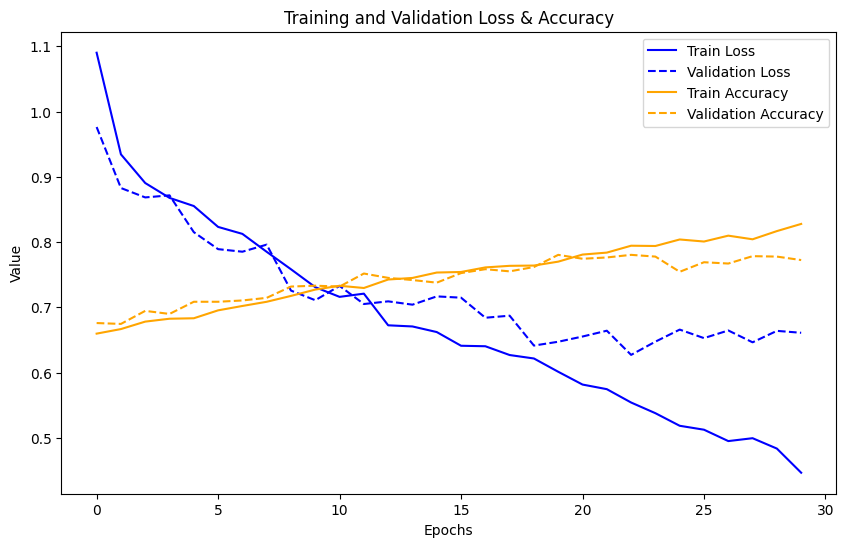

In [ ]:
# plot results
print("\nLoss and accuracy")
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss', linestyle='-', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--', color='blue')
plt.plot(history.history['accuracy'], label='Train Accuracy', linestyle='-', color='orange')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='--', color='orange')
plt.title('Training and Validation Loss & Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

### Evaluate on the Test Set

Report the accuracy on the test set.

In [ ]:
print(f"Training Accuracy: {history.history['accuracy'][-1]:.4f}, Final Training Loss: {history.history['loss'][-1]:.4f}")
print(f"Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}, Final Validation Loss: {history.history['val_loss'][-1]:.4f}")
print(f"Test Accuracy: {final_accuracy:.4f}, Test Loss: {final_loss:.4f}")

Training Accuracy: 0.8278, Final Training Loss: 0.4467
Validation Accuracy: 0.7725, Final Validation Loss: 0.6611
Test Accuracy: 0.7463, Test Loss: 0.7087


### Confusion Matrix

Plot a confusion matrix to evaluate performance for each class.


Confusion matrix
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


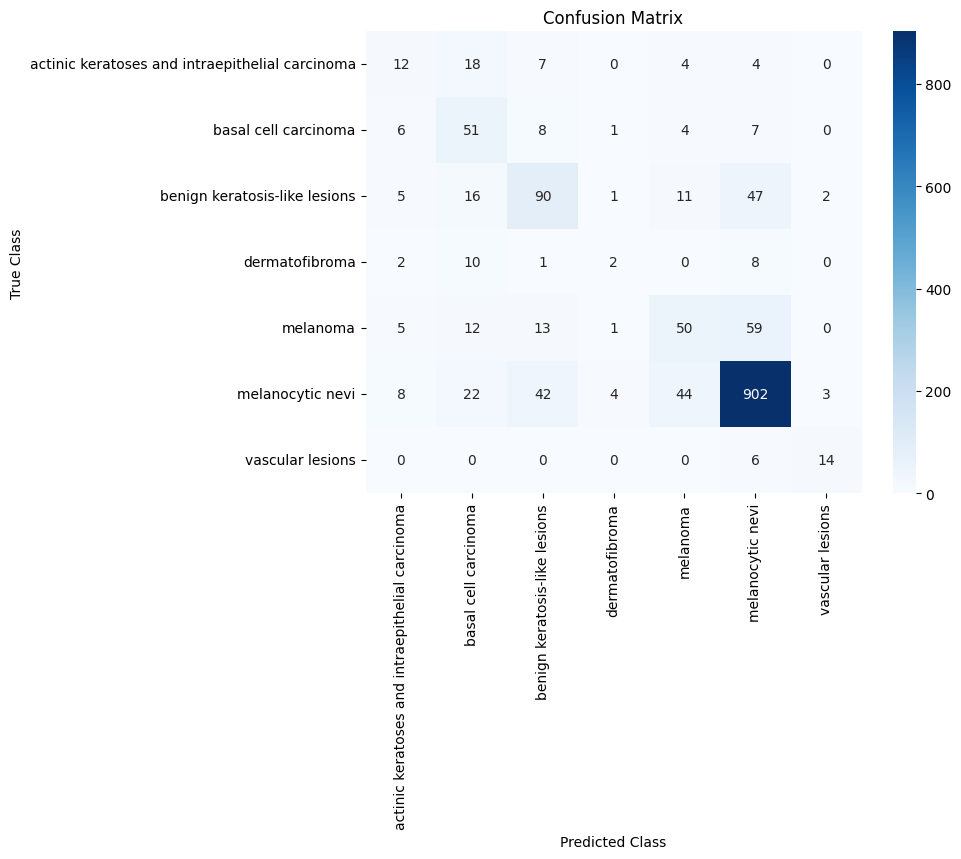

Confusion Matrix:
[[ 12  18   7   0   4   4   0]
 [  6  51   8   1   4   7   0]
 [  5  16  90   1  11  47   2]
 [  2  10   1   2   0   8   0]
 [  5  12  13   1  50  59   0]
 [  8  22  42   4  44 902   3]
 [  0   0   0   0   0   6  14]]

Classification Report:
              precision    recall  f1-score   support

           0       0.32      0.27      0.29        45
           1       0.40      0.66      0.50        77
           2       0.56      0.52      0.54       172
           3       0.22      0.09      0.12        23
           4       0.44      0.36      0.40       140
           5       0.87      0.88      0.88      1025
           6       0.74      0.70      0.72        20

    accuracy                           0.75      1502
   macro avg       0.51      0.50      0.49      1502
weighted avg       0.74      0.75      0.74      1502



In [ ]:
print("\nConfusion matrix")
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels, axis=1)
matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', xticklabels=INFO[data_flag]['label'].values(), yticklabels=INFO[data_flag]['label'].values())
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()


from sklearn.metrics import classification_report
print("Confusion Matrix:")
print(matrix)

report = classification_report(true_labels, predicted_labels)
print("\nClassification Report:")
print(report)

### Save the Trained Model

Save your trained CNN model for future use in .h5 format.
Save Plots and Results

Save the training history plots and evaluation results.

In [ ]:
# Save the model in h5 (legacy)
model.save('/content/drive/MyDrive/Colab Notebooks/trained_models/hw4_model.h5')
# Native Keras format
# model.save('/content/drive/MyDrive/Colab Notebooks/trained_models/hw4_model.keras')
# pickle
# pickle.dump(model, open('/content/drive/MyDrive/Colab Notebooks/trained_models/hw4_model.h5', 'wb'))

# Load the model h5, keras or pickle
loaded_model = load_model('/content/drive/MyDrive/Colab Notebooks/trained_models/hw4_model.h5')
# loaded_model = load_model('/content/drive/MyDrive/Colab Notebooks/trained_models/hw4_model.keras')
# loaded model = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/trained_models/hw4_model.h5', 'rb'))

# print("Loaded model summary")
# loaded_model.summary()

### Findings

The training process shows a pretty steady improvement in accuracy and loss over the 30 epochs, see above. The final training accuracy reached 83.45% with a corresponding loss of around 0.4360. The validation accuracy reached 77.25% with a loss of 0.6611. When evaluated on the test dataset, the model achieved an accuracy of 74.63% and a loss of 0.7087, which is a slight drop compared to the training performance.
The confusion matrix shows that the model performs well on the most frequent class (class 5). It achieved significant precision and recall, but it could perform better on smaller or underrepresented classes like class 3. This was reflected in the weighted average metrics, that is it can be seen that the overall precision, recall, and F1-score were 74%, 75%, and 74%, respectively.
The classification report shows a kind of disparity in performance across classes. Class 5 achieves an F1-score of 0.88, while others, such as class 3, are lower due to limited recall and precision. Based on these findings, the model is generally effective, while its ability to handle imbalanced class distributions and smaller categories could probably be improved.

# Assignment 2: Dataset of your choice (3 points)

Choose a dataset of your choice and repeat the tasks similar to the first assignment.


---




### Load the dataset

In [90]:
data_flag = 'pathmnist'
info = INFO[data_flag]
task = info['task']
classes = INFO[data_flag]['label']
num_classes = len(classes)
print(f"Classes: {classes}")
# print(INFO.keys())
# from pprint import pprint
# pprint(INFO[data_flag])

train_ratio=0.7
test_ratio=0.15
validation_ratio=0.15

DataClass = getattr(medmnist, info['python_class'])
train_dataset_pathmnist = DataClass(split='train', download=True)
test_dataset_pathmnist = DataClass(split='test', download=True)
val_dataset_pathmnist = DataClass(split='val', download=True)

Classes: {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}
Using downloaded and verified file: /root/.medmnist/pathmnist.npz
Using downloaded and verified file: /root/.medmnist/pathmnist.npz
Using downloaded and verified file: /root/.medmnist/pathmnist.npz


### Adjust dataset ratio
see rearrange_data function above for more info

In [91]:
train_dataset, test_dataset, val_dataset = rearrange_data(train_dataset_pathmnist, test_dataset_pathmnist, val_dataset_pathmnist, train_ratio, test_ratio, validation_ratio)

In [92]:
# Resize the data
train_images = resize_and_normalize(train_dataset.imgs)
test_images = resize_and_normalize(test_dataset.imgs)
val_images = resize_and_normalize(val_dataset.imgs)

### One-hot encoding

In [93]:
train_labels = to_categorical(train_dataset.labels, num_classes=num_classes)
val_labels = to_categorical(val_dataset.labels, num_classes=num_classes)
test_labels = to_categorical(test_dataset.labels, num_classes=num_classes)

### Build a CNN Model

In [94]:
model = Sequential()
model.add(Input(shape=(28, 28, 3)))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D((3, 3)))
model.add(Dropout(0.1))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D((3, 3)))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(num_classes, activation='softmax'))

### Compile the model

In [95]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Train the model

In [96]:
history = model.fit(train_images, train_labels, epochs=30, batch_size=64, validation_data=(val_images, val_labels), verbose=1)
final_loss, final_accuracy = model.evaluate(test_images, test_labels)
# model.summary()

Epoch 1/30
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.4570 - loss: 1.4317 - val_accuracy: 0.7363 - val_loss: 0.7039
Epoch 2/30
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.7535 - loss: 0.6799 - val_accuracy: 0.8140 - val_loss: 0.5105
Epoch 3/30
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8091 - loss: 0.5237 - val_accuracy: 0.8048 - val_loss: 0.5232
Epoch 4/30
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8318 - loss: 0.4549 - val_accuracy: 0.8445 - val_loss: 0.4202
Epoch 5/30
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8554 - loss: 0.3949 - val_accuracy: 0.8735 - val_loss: 0.3385
Epoch 6/30
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8727 - loss: 0.3498 - val_accuracy: 0.8909 - val_loss: 0.2858
Epoch 7/30
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.8841 - loss: 0.3202 - val_accuracy: 0.8629 - val_loss: 0.3747
Epoch 8/30
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8902 - loss: 0.2

### Plot training history


Loss and accuracy


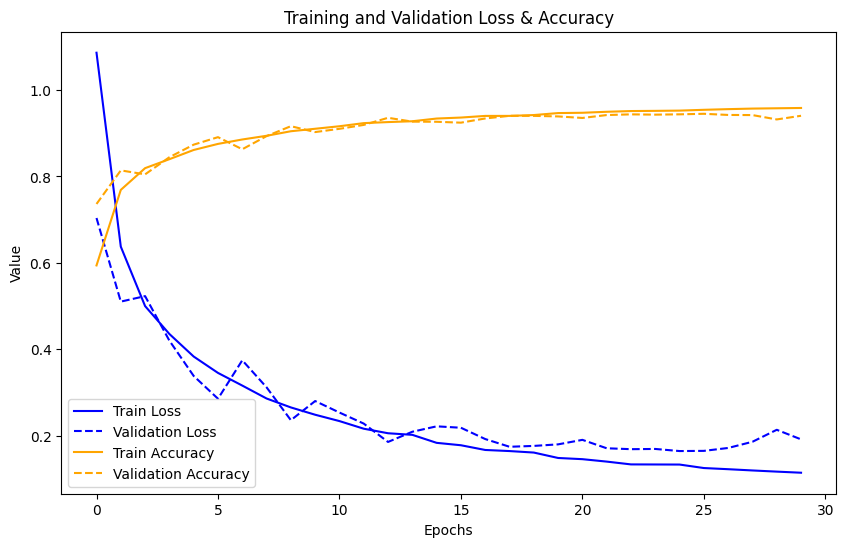

In [97]:
print("\nLoss and accuracy")
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss', linestyle='-', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--', color='blue')
plt.plot(history.history['accuracy'], label='Train Accuracy', linestyle='-', color='orange')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='--', color='orange')
plt.title('Training and Validation Loss & Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

### Evaluate the Test Set

In [98]:
print(f"Training Accuracy: {history.history['accuracy'][-1]:.4f}, Final Training Loss: {history.history['loss'][-1]:.4f}")
print(f"Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}, Final Validation Loss: {history.history['val_loss'][-1]:.4f}")
print(f"Test Accuracy: {final_accuracy:.4f}, Test Loss: {final_loss:.4f}")

Training Accuracy: 0.9584, Final Training Loss: 0.1147
Validation Accuracy: 0.9403, Final Validation Loss: 0.1918
Test Accuracy: 0.9379, Test Loss: 0.1945


### Confusion Matrix


Confusion matrix
503/503 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


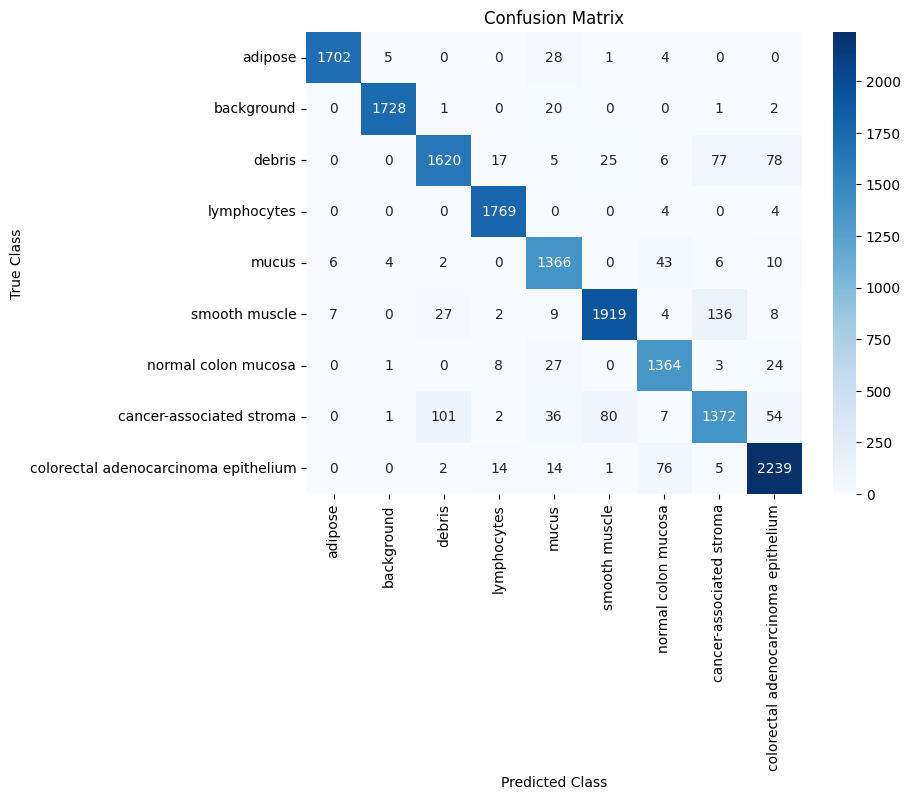

Confusion Matrix:
[[1702    5    0    0   28    1    4    0    0]
 [   0 1728    1    0   20    0    0    1    2]
 [   0    0 1620   17    5   25    6   77   78]
 [   0    0    0 1769    0    0    4    0    4]
 [   6    4    2    0 1366    0   43    6   10]
 [   7    0   27    2    9 1919    4  136    8]
 [   0    1    0    8   27    0 1364    3   24]
 [   0    1  101    2   36   80    7 1372   54]
 [   0    0    2   14   14    1   76    5 2239]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1740
           1       0.99      0.99      0.99      1752
           2       0.92      0.89      0.90      1828
           3       0.98      1.00      0.99      1777
           4       0.91      0.95      0.93      1437
           5       0.95      0.91      0.93      2112
           6       0.90      0.96      0.93      1427
           7       0.86      0.83      0.84      1653
           8       0.93      0.95     

In [99]:
print("\nConfusion matrix")
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels, axis=1)
matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', xticklabels=INFO[data_flag]['label'].values(), yticklabels=INFO[data_flag]['label'].values())
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()


from sklearn.metrics import classification_report
print("Confusion Matrix:")
print(matrix)

report = classification_report(true_labels, predicted_labels)
print("\nClassification Report:")
print(report)

### Save the Model

In [87]:
# Save the model in h5 (legacy)
model.save('/content/drive/MyDrive/Colab Notebooks/trained_models/hw4_model.h5')

# Load the model h5, keras or pickle
loaded_model = load_model('/content/drive/MyDrive/Colab Notebooks/trained_models/hw4_model.h5')

# print("Loaded model summary")
# loaded_model.summary()

### Findings

As the model in the first section of this assignment did not acheieve accuracy higher than 90%, I decided to use it on a larger dataset pathmnist (10 times larger) with 2 more classes (9) than the dermamnist under the same circumstances e.g. the same number of layers, epochs, batch size, etc. Suprisingly, the model performed significantly better, especially regarding the confusion matrix.

For example, the model achieved a test accuracy of 93.79% and the final test loss of 0.1945. Throughout the training process, the accuracy was steadily improving from 45.7% in the first epoch to 95.90% in the final. The validation accuracy peak was at 94.03%. The confusion matrix indicates that the model is very effective at classifying almost all classes. Some categories, such as class 7 (with a recall of 83%), had slightly lower performance. This might be due to class imbalance or complexity. However, the model performs well across all classes, with an overall accuracy of 94%. This indicates solid generalization to the test set. The classification report further supports this findings, but also highlights the model’s precision, recall, and F1-score values for most classes.